In [1]:
import time
import random
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.mixture import GaussianMixture 
from hmmlearn.hmm import GaussianHMM

from matplotlib import cm, pyplot as plt
from sklearn.metrics import mean_squared_error, confusion_matrix

# Include to avoid errors
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline 

### LOAD AND PROCESS THE DATA

First, the different assests are loaded into the notebook and merged into a dataframe. In order to be able to compare the different assets, only the dates for which there is data available for all the assets are maintained.

In [2]:
# Collect the name of the asset that are going to be analysed in the project
assets_name = ['IBEX', 'CAC', 'Nikkei']

# Create an array with the name of the files that contain the data studied in the project
files_to_test = ['^IBEX.csv', '^FCHI.csv', '^N225.csv']

# Initilize the dataframes
assets_df = pd.DataFrame()

# The different columns available of the asset assets
df_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

for name, file in zip(assets_name, files_to_test):
    # Load the data of each file into an intermediate dataframe
    asset = pd.DataFrame(pd.read_csv(file, index_col = 'Date', parse_dates = True))
    # Change the names of the columns to include the name of the asset
    asset.columns = [col + '_' + name for col in df_columns]
    # Remove rows with volume 0 because it implies that no share on the asset has been traded that day and therefore,
    # the prices may be irreal. However, this value was not registered until 2005
    asset = asset[(asset.index.year <= 2005) | (asset['Volume' + '_' + name] != 0) & (asset.index.year > 2005)]
    
    # Add the data to the final dataframe with all the assets
    assets_df = pd.concat([assets_df, asset], axis = 1)

# Remove the dates that have no information for some of the assets    
assets_df.dropna(how = 'any', inplace = True)

assets_df

,Open_IBEX,High_IBEX,Low_IBEX,Close_IBEX,Adj Close_IBEX,Volume_IBEX,Open_CAC,High_CAC,Low_CAC,Close_CAC,Adj Close_CAC,Volume_CAC,Open_Nikkei,High_Nikkei,Low_Nikkei,Close_Nikkei,Adj Close_Nikkei,Volume_Nikkei
Date,,,,,,,,,,,,,,,,,,
1993-02-15,9834.599609,9913.400391,9764.099609,9865.299805,9865.290039,10256100.0,1908.500000,1917.000000,1896.599976,1899.500000,1899.500000,0.0,16883.619141,17117.990234,16829.039063,17117.990234,17117.990234,0.0
1993-03-19,9393.299805,9393.299805,9243.000000,9251.299805,9251.290039,6878000.0,1956.199951,1968.699951,1947.199951,1962.699951,1962.699951,0.0,18738.640625,18835.960938,18503.160156,18537.169922,18537.169922,0.0
1993-04-06,2612.300049,2612.300049,2599.300049,2603.199951,2603.197266,0.0,1984.000000,1998.699951,1979.800049,1995.300049,1995.300049,0.0,19748.919922,19748.919922,19386.710938,19486.800781,19486.800781,0.0
1993-04-07,2596.800049,2596.800049,2574.399902,2595.199951,2595.197266,0.0,2005.199951,2007.599976,1974.300049,1984.000000,1984.000000,0.0,19506.580078,20054.509766,19506.580078,19829.230469,19829.230469,0.0
1993-04-13,2612.600098,2633.699951,2612.600098,2630.899902,2630.897217,0.0,2001.800049,2021.599976,2000.099976,2018.099976,2018.099976,0.0,19902.419922,20753.740234,19902.419922,20740.289063,20740.289063,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-24,7403.899902,7440.899902,7195.500000,7195.500000,7195.500000,248464400.0,4985.629883,5004.040039,4871.359863,4871.359863,4871.359863,97104300.0,22541.009766,22663.289063,22479.859375,22534.320313,22534.320313,67000.0
2020-06-25,7176.399902,7295.799805,7077.799805,7270.299805,7270.299805,267871700.0,4860.160156,4941.959961,4795.049805,4918.580078,4918.580078,99381800.0,22287.869141,22423.410156,22165.140625,22259.789063,22259.789063,80800.0
2020-06-26,7324.500000,7344.899902,7172.100098,7178.399902,7178.399902,215724300.0,4965.720215,5014.830078,4908.149902,4909.640137,4909.640137,84000.0,22424.369141,22589.140625,22408.269531,22512.080078,22512.080078,66600.0


#### DEFINE FUNCTIONS TO ANALYZE THE DATA

Once the data is loaded, proceed to analyse the data.

The following figure presents the asset series of all the series that are going to be analysed in this project, each in their actual currency. The Nikkei is in yens (¥) and the other two in euros (€). 

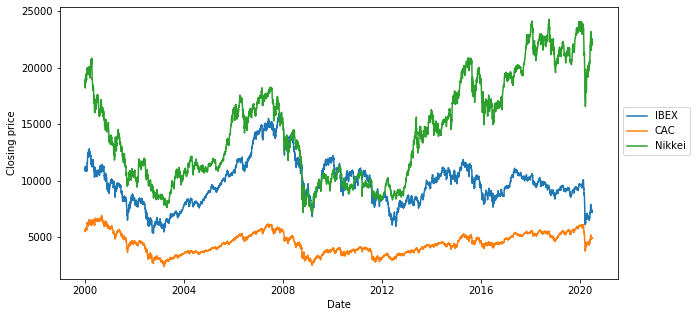

In [3]:
plt.figure(figsize = (10, 5))
for asset in assets_name:
    plt.plot(assets_df['Close_' + asset][(assets_df.index.year >= 2000) & (assets_df.index.year <= 2020)])
    plt.xlabel('Date')
    plt.ylabel('Closing price')
    plt.legend(labels = assets_name, loc = 2, bbox_to_anchor = (1, 0.65))

**RETURN**

The return is the normalized difference of the price of the asset:

$Open-to-Close Return = \frac{Closing Price - Opening Price}{Opening Price}$

Instead of considerding close-to-close returns, open-to-close returns are used because if close-to-close was considered, the return from the time lapse between the market close on Friday to the close on Monday is not the same as the close-to-close during the week days. 

The following function creates a dataframe that contains the return of all the assets that are going to be studied.  

In [4]:
def open_close_return_assets(data, init_year = 1992, end_year = 2020):
    
    # Initialize the dataframe
    open_close_returns_df = pd.DataFrame()
    
    # Initialize the column index for the different assets
    i = 0
    
    # For every asset contained in the 'assets_name' list
    for asset in assets_name:
        open_close_returns_df.insert(loc = i, column = asset, 
                          value = (data['Close_' + asset] - data['Open_' + asset]) / data['Open_' + asset])
        i += 1
    
    # The rows with null returns are removed are due to not having data for that day or having open = 0
    open_close_returns_df.dropna(how = 'any', inplace = True)
    
    open_close_returns_df = open_close_returns_df[(open_close_returns_df.index.year >= init_year) & 
                                                  (open_close_returns_df.index.year <= end_year)]
    
    # Plot the return of all the assets in a single plot after computing the return for all of them 
    fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (9, 10), sharey = True)
    fig.tight_layout(pad = 2)

    for i, asset in enumerate(assets_name):
        ax[i].plot(open_close_returns_df[asset], color = 'C' + str(i))
        ax[i].set_xlabel('Date')
        ax[i].set_ylabel('Open-to-Close returns')
        ax[i].set_title(asset)
    
    return open_close_returns_df

View of all the asset returns separately for a clearer visualization.

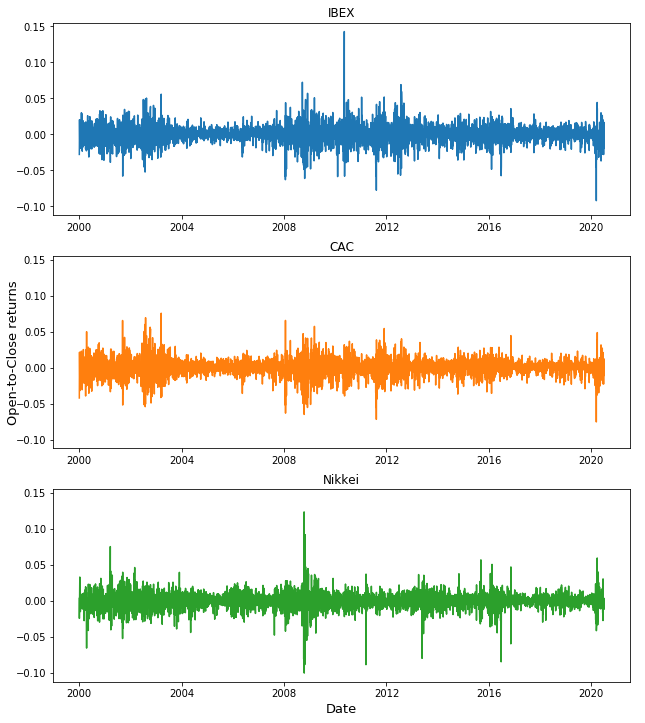

In [5]:
open_close_returns_df = open_close_return_assets(assets_df, init_year = 2000, end_year = 2020)

In [6]:
open_close_returns_df

,IBEX,CAC,Nikkei
Date,,,
2000-01-04,-0.028049,-0.042249,0.003454
2000-01-05,-0.018522,-0.007630,-0.024257
2000-01-07,0.020188,0.021337,-0.000035
2000-01-11,-0.014400,-0.019665,0.033148
2000-01-12,-0.008705,0.007448,-0.005471
...,...,...,...
2020-06-24,-0.028147,-0.022920,-0.000297
2020-06-25,0.013085,0.012020,-0.001260
2020-06-26,-0.019947,-0.011293,0.003911


### Train and test data
The train data corresponds to data from 2000 to 2018 and the test data is 2019 and 2020. This is, the prediction is focused in recent years.

Therefore, the first step is to define a function that providing the return series of a given asset and the start and partition years retrieves the training and testing partitions.

In [7]:
def train_test_df(open_close_returns, test_year, start_year = 2000, partition_year = 2018):
    
    # The training data between the start and the partition year which we are going to start considering 2016 and 2018
    returns_train = open_close_returns[(open_close_returns.index.year >= start_year) & 
                                       (open_close_returns.index.year <= partition_year)]
    
    # The testing data will initially only contain information of the indicated one year
    returns_test = open_close_returns[open_close_returns.index.year == test_year]
    
    return returns_train, returns_test

Apply the function to obtain the training and testing data

In [8]:
returns_train_IBEX, returns_test2019_IBEX = train_test_df(open_close_returns_df['IBEX'], 
                                                          partition_year = 2018, test_year = 2019)

returns_train_IBEX, returns_test2020_IBEX = train_test_df(open_close_returns_df['IBEX'], 
                                                          partition_year = 2018, test_year = 2020)

In [9]:
returns_train_CAC, returns_test2019_CAC = train_test_df(open_close_returns_df['CAC'],
                                                          partition_year = 2018, test_year = 2019)

returns_train_CAC, returns_test2020_CAC = train_test_df(open_close_returns_df['CAC'],
                                                          partition_year = 2018, test_year = 2020)

In [10]:
returns_train_NIK, returns_test2019_NIK = train_test_df(open_close_returns_df['Nikkei'],
                                                          partition_year = 2018, test_year = 2019)

returns_train_NIK, returns_test2020_NIK = train_test_df(open_close_returns_df['Nikkei'],
                                                          partition_year = 2018, test_year = 2020)

## Step 1: find the best window size to define the volatility

Volatility is the standard deviation of the return and assuming that the returns have a 0 mean, then the series of returns can be modified to consider it as a series of volatilities, the estimation of the variance is given by the following formula 

$$\hat{\sigma}^2 = E(X^2) - E(X)^2 = E(X^2)$$ 

This is equivalent to considering 

$$\hat{\sigma}^2 = \frac{1}{m} \Sigma_{i=1}^{m} x_i^2$$

In the context of rolling window analysis, the volatility is computed for the days within the window of size $m$, so the variance is computed by elevating the returns to the square, taking those squared values prior to the day that is being considered and computing the mean for those values. Moving the days one ahead, the predicted volatility is obtained.

When there is only one sample to estimate the volatility, the previous expression is transformed into 
$$\hat{\sigma}^2 = \frac{1}{1} \Sigma_{i=1}^{1} x_i^2 = x_i^2$$
When taking the standard deviation, this becomes $\hat{\sigma} = |X|$.

Therefore, the considered approach is a comparison between the predicted volatility, computed with the returns observed during the previous days, and the observed volatility. 

The following function selects the window size as the window size whose linear combination of the data within the window predicts the one-day volatility producting the smallest error.

Assuming that the returns have a 0 mean, then the serie of returns can be considered as a serie of volatilities.
% In the scenary where the mean is 0, the estimation of the variance is given by the following formula $\hat{\sigma}^2 = E(X^2) - E(X)^2 = E(X^2)$. This is equivalent to $\hat{\sigma}^2 = \frac{1}{m} \Sigma_{i=1}^{m} x_i^2$
Here the volatility is going to be computed for the days within the window size, so the variance is going to be computed by elevating the returns to the square, taking those squared values prior to the day that is being considered and taking the mean for those values. Therefore, the volatility for each day, being the standard deviation, is the square root of the corresponding value after that process. Moving the days one ahead, the predicted volatility is obtained.

When there is only one sample to estimate the volatility, the previous expression is transformed into $\hat{\sigma}^2 = \frac{1}{1} \Sigma_{i=1}^{1} x_i^2 = x_i^2$, which when taking the standard deviation becomes $\hat{\sigma} = |X|$.

The following function selects the window size fitting a linear regression model fitting the data within each window to predict the one day volatility and the model that obtains a smaller error between the predicted value for the testing data distributed in window and the one day volatility of the test data.
Once the predicted volatility is obtained, it is compared with the volatility computed only considering the data of that precise day.
In the following function, the returns are used to predict the volatility of the following day and the estimated volatility is saved for plotting it.

In [11]:
def select_window(returns_train, window_sizes):
    
    # Define a dataset in which store the different volatilities estimated by different windows
    predict_volatility = pd.DataFrame(index = returns_train.shift(1).index, columns = window_sizes)

    # Initialize the vector to store the error for the different window size 
    RMSE_windows = []    
    
    for i in range(len(window_sizes)):# for each explored window size 
        size = window_sizes[i] 
        
        # Predict the volatility for each window considering the observations within that window as the sample to which compute
        # the standard deviation, the square root of the mean of the squared returns
        window_volatility = returns_train.apply(lambda x:x**2).rolling(window = size).mean().apply(lambda x:np.sqrt(x))
        
        # As this is going to be used as the predicted volatility for the following day, the series is shifted in one unit
        predict_volatility[size] = window_volatility.shift(1)
        
        RMSE_windows.append(mean_squared_error(predict_volatility.iloc[size:, i], 
                                               returns_train.apply(np.absolute).iloc[size:], squared = False))
                      
    plt.plot(window_sizes, RMSE_windows)
    plt.xlabel('Window size (days)')
    plt.ylabel('RMSE')
    plt.grid()
    
    # After doing this for the different window sizes, the size for which the smallest average error is obtained is returned
    print('The minimum error is {0:.7f} obtained for window size {1}'.format(min(RMSE_windows), 
                                                                             window_sizes[np.argmin(RMSE_windows)]))

    return window_sizes[np.argmin(RMSE_windows)], predict_volatility[window_sizes[np.argmin(RMSE_windows)]].dropna() 

### Analyse the assets
Applying the function considering the following different window sizes:

- **IBEX**

The minimum error is 0.0089503 obtained for window size 30


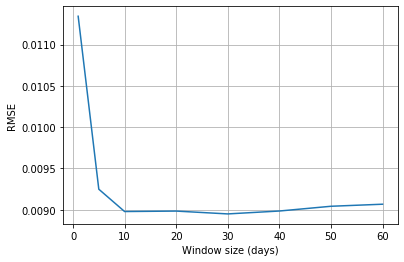

In [12]:
window_sizes = [1, 5, 10, 20, 30, 40, 50, 60] 

size_IBEX = select_window(returns_train_IBEX, window_sizes = window_sizes)

Despite the best window size being obtained for 30 days, the improvement is not remarkable from considering 10 days, so this amount is considered a good approximation to it.

Comparison of the one-day volatility series versus the volatility series estimated considering a window size of 10 days.

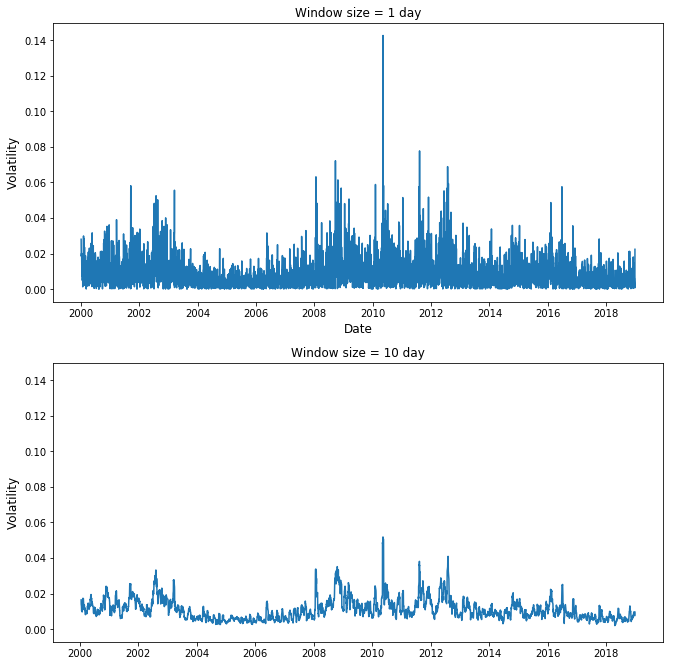

In [13]:
one_day_train_IBEX = returns_train_IBEX.apply(lambda x:x**2).rolling(window = 1).mean().apply(lambda x:np.sqrt(x)).shift(1)

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (10, 10), sharey = True)
fig.tight_layout(pad = 4)

ax1.plot(one_day_train_IBEX, color = 'C0')
ax1.set_xlabel('Date', fontsize = 12)
ax1.set_ylabel('Volatility', fontsize = 12)
ax1.set_title('Window size = 1 day')

window_volatility = returns_train_IBEX.apply(lambda x:x**2).rolling(window = 10).mean().apply(lambda x:np.sqrt(x)).shift(1)
ax2.plot(window_volatility, color = 'C0')
ax1.set_xlabel('Date', fontsize = 12)
ax2.set_ylabel('Volatility', fontsize = 12)
ax2.set_title('Window size = 10 day')

fig.add_subplot(111, frameon = False)
plt.tick_params(labelcolor = 'none', top = False, bottom = False, left = False, right = False);

- **CAC**

The minimum error is 0.0082350 obtained for window size 20


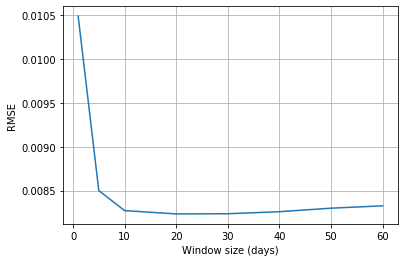

In [14]:
window_sizes = [1, 5, 10, 20, 30, 40, 50, 60] 

size_CAC = select_window(returns_train_CAC, window_sizes = window_sizes)

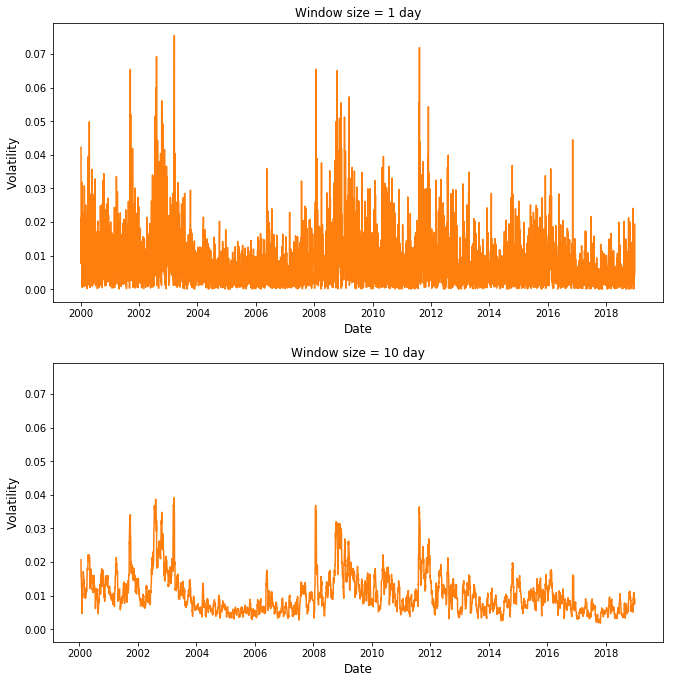

In [15]:
one_day_train_CAC = returns_train_CAC.apply(lambda x:x**2).rolling(window = 1).mean().apply(lambda x:np.sqrt(x)).shift(1)

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (10, 10), sharey = True)
fig.tight_layout(pad = 4)

ax1.plot(one_day_train_CAC, color = 'C1')
ax1.set_xlabel('Date', fontsize = 12)
ax1.set_ylabel('Volatility', fontsize = 12)
ax1.set_title('Window size = 1 day')

window_volatility = returns_train_CAC.apply(lambda x:x**2).rolling(window = 10).mean().apply(lambda x:np.sqrt(x)).shift(1)
ax2.plot(window_volatility, color = 'C1')
ax2.set_xlabel('Date', fontsize = 12)
ax2.set_ylabel('Volatility', fontsize = 12)
ax2.set_title('Window size = 10 day')

fig.add_subplot(111, frameon = False)
plt.tick_params(labelcolor = 'none', top = False, bottom = False, left = False, right = False);

- **Nikkei**

The minimum error is 0.0082863 obtained for window size 10


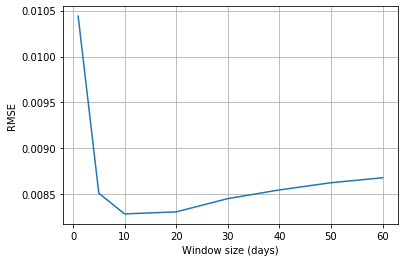

In [16]:
window_sizes = [1, 5, 10, 20, 30, 40, 50, 60] 

size_NIK = select_window(returns_train_NIK, window_sizes = window_sizes)

In this case, the best window size is 10 so the volatility series compared in the select_window function with the one-day volatility is considered for the plot comparison too.

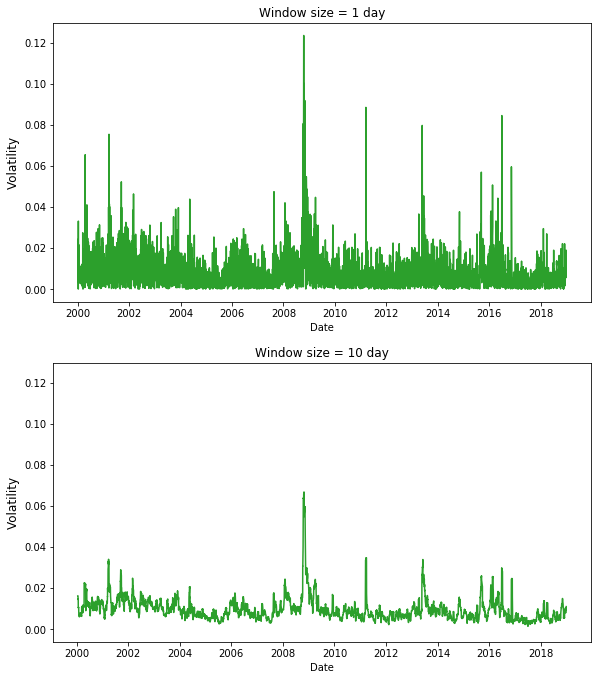

In [17]:
one_day_train_NIK =  returns_train_NIK.apply(lambda x:x**2).rolling(window = 1).mean().apply(lambda x:np.sqrt(x)).shift(1)

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (9, 10), sharey = True)
fig.tight_layout(pad = 4)

ax1.plot(one_day_train_NIK, color = 'C2')
ax1.set_xlabel('Date')
ax1.set_ylabel('Volatility', fontsize = 12)
ax1.set_title('Window size = 1 day')

ax2.plot(size_NIK[1], color = 'C2')
ax2.set_xlabel('Date')
ax2.set_ylabel('Volatility', fontsize = 12)
ax2.set_title('Window size = 10 day')

fig.add_subplot(111, frameon = False)
plt.tick_params(labelcolor = 'none', top = False, bottom = False, left = False, right = False);

## Step 2: fitting the models to predict regimes within the volatility

Once the consistency of considering the existence of regimes has been proved, the models for detecting them are implemented. 

### Gaussian Mixture Models

**Defining the functions**

In [18]:
def GMM_best(returns_train, K_max = 6, cov_type = 'full'):
        
    random.seed(0)
    
    # Separating the last year of the training data to consider as the validation year to obtain the best window size
    returns_validation = returns_train[returns_train.index.year == returns_train.index.year[-1]]
    ret_train = returns_train[returns_train.index.year < returns_train.index.year[-1]]
    #print(returns_validation.index, ret_train.index)
    
    # Get an array from the time series and reshape it as a 2D array to pass to the GMM
    returns_train_values = ret_train.values.reshape(-1, 1)
    returns_valid_values = returns_validation.values.reshape(-1, 1)

    oneday_volat_valid = abs(returns_valid_values)
        
    # Fit models with 1 and K_max components. By default, the maximum number of components that evaluated is 6
    K_list = np.arange(1, K_max + 1) 
    
    RMSE_GMM = [None for i in K_list]
    models = [None for i in K_list]

    for i in range(len(K_list)):
        # Fit the model for the training returns series
        models[i] = GaussianMixture(K_list[i], covariance_type = cov_type).fit(returns_train_values)
        
        # Predict the regimes for the days in the test data
        state_true = models[i].predict(returns_valid_values)
        
        # Check if there is a state with only 1 day or there is a state defined but with no day labeled there
        unique, unique_counts = np.unique(state_true, return_counts = True)
        if np.any(unique_counts <= 1) == True or len(unique)!=(i+1): 
            # This introduces NaN into the BIC array instead of an actual value so that this K is ignored as best model
            RMSE_GMM[i] = np.nan
        else:  
            # Initilize a vector to collect the estimated volatility for the days in the test partition
            expected_variance = []
        
            # Depending on the component to which it has been associated, given then the value of the variance of the component
            for comp in state_true:
                expected_variance.append(models[i].covariances_[comp][0][0])
                
            # Compare the value of the estimated variance and the actual volatility
            RMSE_GMM[i] = mean_squared_error(oneday_volat_valid, np.sqrt(expected_variance), squared = False)
    
    #print(RMSE_GMM) 
    
    # Obtain best model based on minimum RMSE   
    print('Minimum RMSE is {0:.6f} for {1} hidden states \n'.format(np.nanmin(RMSE_GMM), 
                                                                    np.where(RMSE_GMM == np.nanmin(RMSE_GMM))[0][0] + 1))
    
    M_best = models[np.where(RMSE_GMM == np.nanmin(RMSE_GMM))[0][0]]

    # When executed, it presents the main properties of the components of the best model
    for i in range(M_best.n_components):
        print('\nMixture component', i)
        print('Mean: ', M_best.means_[i])
        print('Volatility: \n', np.sqrt(M_best.covariances_[i]))
        print('Prior: %2f' % M_best.weights_[i])

    # Plot the RMSE values for the different explored values of K
    plt.plot(K_list, RMSE_GMM)
    sns.scatterplot(np.arange(1, K_max + 1), RMSE_GMM)
    plt.xlabel('Number of components')
    plt.ylabel('RMSE')
    plt.grid()
    
    return M_best

In [19]:
def GMM_model(returns_train, cov_type = 'full'):
        
    #random.seed(0)
    
    # Separating the last year of the training data to consider as the validation year to obtain the best window size
    returns_validation = returns_train[returns_train.index.year == returns_train.index.year[-1]]
    ret_train = returns_train[returns_train.index.year < returns_train.index.year[-1]]
    #print(returns_validation.index, ret_train.index)
    
    # Get an array from the time series and reshape it as a 2D array to pass to the GMM
    returns_train_values = ret_train.values.reshape(-1, 1)
    returns_valid_values = returns_validation.values.reshape(-1, 1)

    oneday_volat_valid = abs(returns_valid_values)
        

    # Fit the model for the training returns series
    model = GaussianMixture(n_components = 2, covariance_type = cov_type).fit(returns_train_values)
        
    # Predict the regimes for the days in the test data
    state_true = model.predict(returns_valid_values)
        
    # Initilize a vector to collect the estimated volatility for the days in the test partition
    expected_variance = []
        
    # Depending on the component to which it has been associated, given then the value of the variance of the component
    for comp in state_true:
        expected_variance.append(model.covariances_[comp][0][0])
    
    # Obtain best model based on minimum RMSE   
    print('Minimum RMSE is {0:.6f} for 2 hidden states \n'.format(mean_squared_error(oneday_volat_valid, 
                                                                                     np.sqrt(expected_variance), squared = False)))
    
    # When executed, it presents the main properties of the components of the best model
    for i in range(model.n_components):
        print('\nMixture component', i)
        print('Mean: ', model.means_[i])
        print('Volatility: \n', np.sqrt(model.covariances_[i]))
        print('Prior: %2f' % model.weights_[i])

    return model

In [20]:
def plot_gmm(returns, model):
    fig = plt.figure(figsize = (20, 5))
    ax = fig.add_subplot(131)

    # The range of the x axis of the plot, reshaped to have 1 column as the data for which the model has been trained
    x = np.sort(returns.values).reshape(-1, 1)
    logprob = model.score_samples(x)
    pdf = np.exp(logprob) #1 column
    
    # Predict posterior probability of each component given the data
    responsibilities = model.predict_proba(x) #As many columns as components
    pdf_individual = responsibilities * pdf[:, np.newaxis] #'np.newaxis' to transform from array (_,) to column vector (_, 1)
    ax.hist(returns, 30, density = True, histtype = 'stepfilled', alpha = 0.4)
    ax.plot(x, pdf, '-k')
    ax.plot(x, pdf_individual, '--k')
    ax.set_xlim(-0.06, 0.06)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$p(x)$');

In [21]:
def plot_component_changes(returns, model):

    returns_values = returns.values.reshape(-1, 1)
            
    # Present the plot of the open-close return
    plt.figure(figsize = (12, 6))
    plt.plot(returns.index, returns_values, color = 'k', linewidth = 1.2)
    plt.xlabel('Date', fontsize = 12)
    plt.ylabel('Open-to-Close return', fontsize = 12)
    
    # But classify the days based on the component predicted for the return (because the model is trained with returns)
    component = model.predict(returns_values)
    
    index_order_variance = np.argsort(model.covariances_, axis = 0)
    labels = ['Low', 'High'] # The labels in increasing order 
    labels_ordered = []
    for i in enumerate(labels):
        labels_ordered.append(labels[index_order_variance[i[0]][0][0]])   
        
    # Filled based on that given component
    for i in range(len(index_order_variance)):
        plt.fill_between(returns.index, min(returns_values), max(returns_values), where = (component == i), alpha = 0.3, 
                         color = 'C' + str(index_order_variance[i][0][0]), label = labels_ordered[i] + ' volatility regime')
            
    plt.legend(fontsize = 12)

In [22]:
def plot_component_changes_test(returns, model, min_assets_test, max_assets_test, ax):

    returns_values = returns.values.reshape(-1, 1)
            
    # Present the plot of the open-close return
    ax.plot(returns.index, returns_values, color = 'k', linewidth = 1.2)
    ax.set_xlabel('Date', fontsize = 12)
    ax.set_ylabel('Open-to-Close return', fontsize = 12)
    
    # But classify the days based on the component predicted for the return (because the model is trained with returns)
    component = model.predict(returns_values)
         
    index_order_variance = np.argsort(model.covariances_, axis = 0)
    labels = ['Low', 'High'] # The labels in increasing order 
    labels_ordered = []
    for i in enumerate(labels):
        labels_ordered.append(labels[index_order_variance[i[0]][0][0]])   
        
    # Filled based on that given component
    for i in range(len(index_order_variance)):
        ax.fill_between(returns.index, min_assets_test, max_assets_test, where = (component == i), alpha = 0.3, 
                         color = 'C' + str(index_order_variance[i][0][0]), label = labels_ordered[i] + ' volatility regime')
           
    ax.legend(fontsize = 12)

The following function serves to identify the proportion of days within each component and the RMSE obtained in the classification.

In [23]:
def components_info(returns, model):
    returns_values = returns.values.reshape(-1, 1)
    oneday_volatility = returns.apply(np.absolute)

    components = model.predict(returns_values)
    for i in np.unique(components):
        print('Proportion of days in regime {0} = {1:.5f}'.format(i, np.count_nonzero(components == i)/len(components)))    
    
    expected_variance = []
    for comp in components:
        expected_variance.append(model.covariances_[comp][0][0])
        
    print('\nRMSE = {0:.5f}'.format(mean_squared_error(oneday_volatility, np.sqrt(expected_variance), squared = False)))

### Analysing the indexes

- **IBEX**

Minimum RMSE is 0.004957 for 2 hidden states 


Mixture component 0
Mean:  [0.00042775]
Volatility: 
 [[0.00816009]]
Prior: 0.681407

Mixture component 1
Mean:  [-0.00187191]
Volatility: 
 [[0.01967572]]
Prior: 0.318593


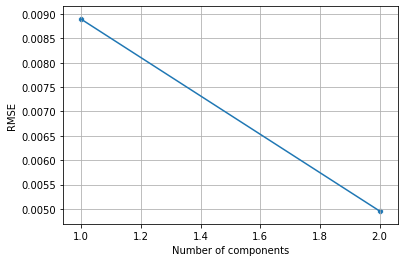

In [32]:
bestgmm_IBEX = GMM_best(returns_train_IBEX)

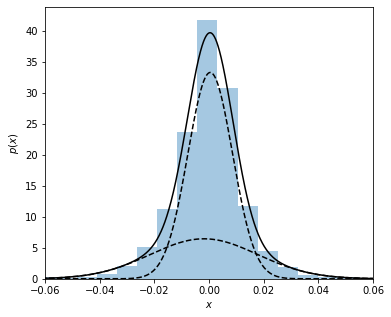

In [33]:
plot_gmm(returns_train_IBEX, bestgmm_IBEX) 

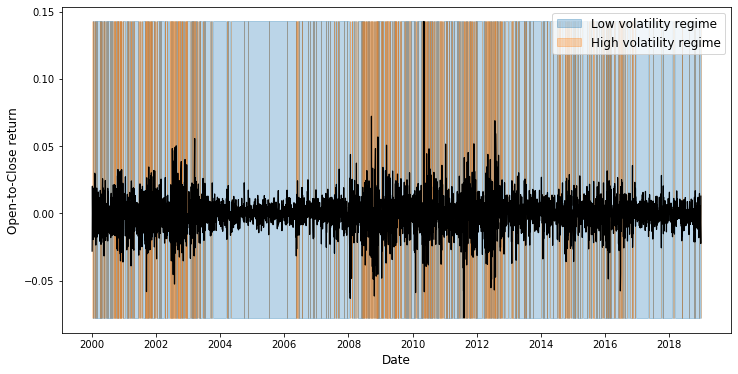

In [34]:
plot_component_changes(returns_train_IBEX, bestgmm_IBEX)

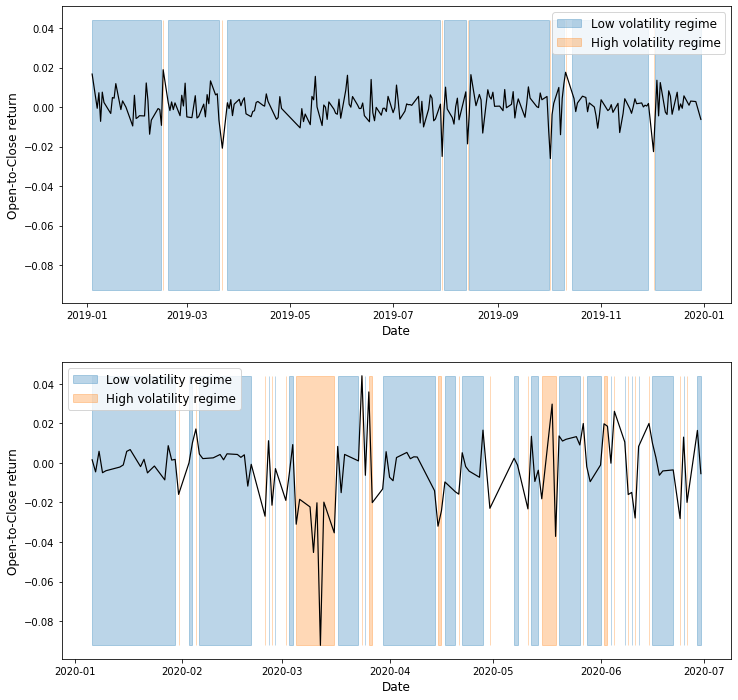

In [35]:
ff, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 12), sharey = True)
assets_test = pd.concat([returns_test2019_IBEX, returns_test2020_IBEX], axis = 0)

plot_component_changes_test(returns_test2019_IBEX, bestgmm_IBEX, min(assets_test), max(assets_test), ax1)
plot_component_changes_test(returns_test2020_IBEX, bestgmm_IBEX, min(assets_test), max(assets_test), ax2)

In [36]:
returns_validation_IBEX = returns_train_IBEX[returns_train_IBEX.index.year == returns_train_IBEX.index.year[-1]]
ret_train_IBEX = returns_train_IBEX[returns_train_IBEX.index.year < returns_train_IBEX.index.year[-1]]

In [37]:
components_info(ret_train_IBEX, bestgmm_IBEX)

Proportion of days in regime 0 = 0.83539
Proportion of days in regime 1 = 0.16461

RMSE = 0.00644


In [38]:
components_info(returns_validation_IBEX, bestgmm_IBEX)

Proportion of days in regime 0 = 0.96218
Proportion of days in regime 1 = 0.03782

RMSE = 0.00496


In [39]:
components_info(returns_test2019_IBEX, bestgmm_IBEX)

Proportion of days in regime 0 = 0.97009
Proportion of days in regime 1 = 0.02991

RMSE = 0.00513


In [40]:
components_info(returns_test2020_IBEX, bestgmm_IBEX)

Proportion of days in regime 0 = 0.71304
Proportion of days in regime 1 = 0.28696

RMSE = 0.00932


As the best model for predicting the volatility of 2020 is also of 2 components, there is no need to plot it again because it is going to be the same.
However, the model for the year 2019 with the same amount of days as the model for 2020 is also explored to be able to compare the errors.

In [41]:
returns_test_h2019_IBEX = returns_test2019_IBEX[returns_test2019_IBEX.index <= '2019-06-30']

components_info(returns_test_h2019_IBEX, bestgmm_IBEX)

Proportion of days in regime 0 = 0.98246
Proportion of days in regime 1 = 0.01754

RMSE = 0.00515


- **CAC**

Minimum RMSE is 0.004067 for 3 hidden states 


Mixture component 0
Mean:  [0.00029699]
Volatility: 
 [[0.0069014]]
Prior: 0.672425

Mixture component 1
Mean:  [-0.01315948]
Volatility: 
 [[0.01423844]]
Prior: 0.161559

Mixture component 2
Mean:  [0.00953007]
Volatility: 
 [[0.01542294]]
Prior: 0.166016


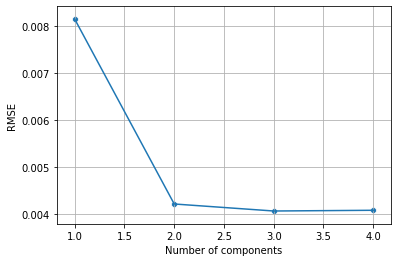

In [44]:
bestgmm_CAC = GMM_best(returns_train_CAC)

In [45]:
bestgmm_CAC = GMM_model(returns_train_CAC)

Minimum RMSE is 0.004482 for 2 hidden states 


Mixture component 0
Mean:  [0.00028806]
Volatility: 
 [[0.00755909]]
Prior: 0.716655

Mixture component 1
Mean:  [-0.00194329]
Volatility: 
 [[0.01927828]]
Prior: 0.283345


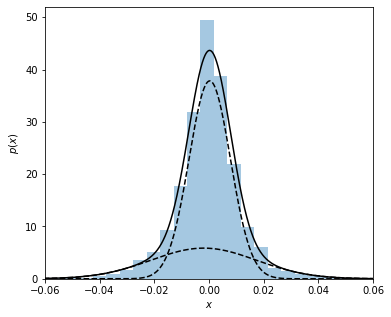

In [46]:
plot_gmm(returns_train_CAC, bestgmm_CAC) 

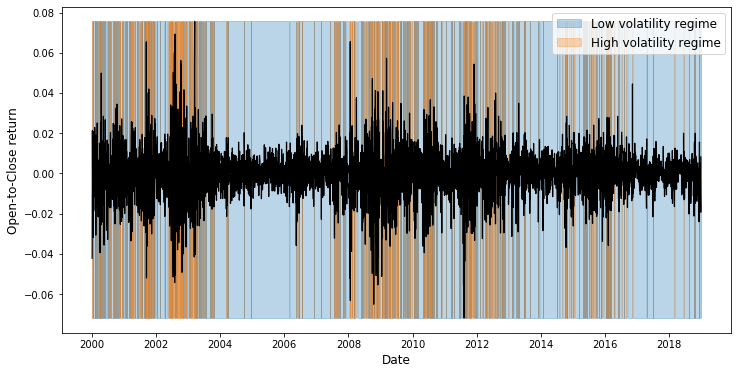

In [47]:
plot_component_changes(returns_train_CAC, bestgmm_CAC)

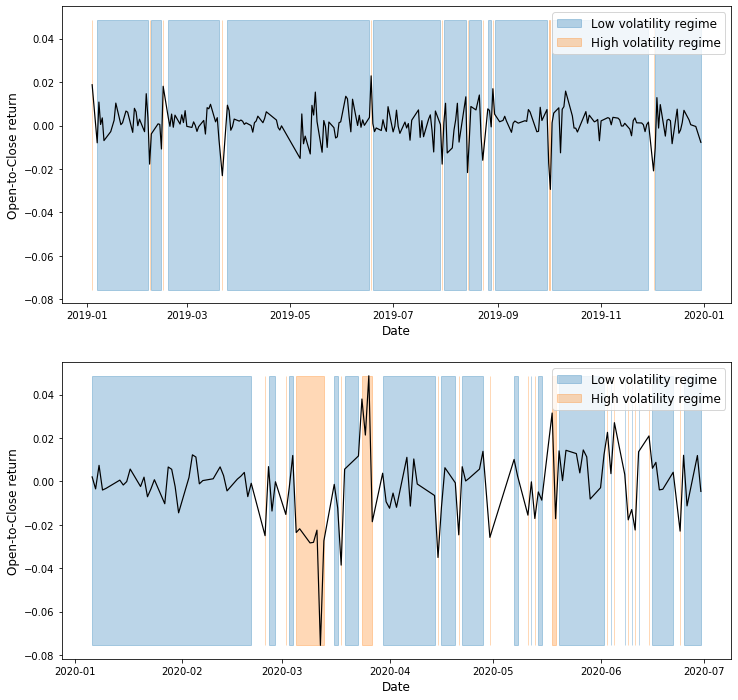

In [48]:
ff, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 12), sharey = True)
assets_test = pd.concat([returns_test2019_CAC, returns_test2020_CAC], axis = 0)

plot_component_changes_test(returns_test2019_CAC, bestgmm_CAC, min(assets_test), max(assets_test), ax1)
plot_component_changes_test(returns_test2020_CAC, bestgmm_CAC, min(assets_test), max(assets_test), ax2)

In [49]:
returns_validation_CAC = returns_train_CAC[returns_train_CAC.index.year == returns_train_CAC.index.year[-1]]
ret_train_CAC = returns_train_CAC[returns_train_CAC.index.year < returns_train_CAC.index.year[-1]]

In [50]:
components_info(ret_train_CAC, bestgmm_CAC)

Proportion of days in regime 0 = 0.84910
Proportion of days in regime 1 = 0.15090

RMSE = 0.00596


In [51]:
components_info(returns_validation_CAC, bestgmm_CAC)

Proportion of days in regime 0 = 0.97059
Proportion of days in regime 1 = 0.02941

RMSE = 0.00448


In [52]:
components_info(returns_test2019_CAC, bestgmm_CAC)

Proportion of days in regime 0 = 0.94872
Proportion of days in regime 1 = 0.05128

RMSE = 0.00488


In [53]:
components_info(returns_test2020_CAC, bestgmm_CAC)

Proportion of days in regime 0 = 0.76522
Proportion of days in regime 1 = 0.23478

RMSE = 0.00813


In [54]:
returns_test_h2019_CAC = returns_test2019_CAC[returns_test2019_CAC.index <= '2019-06-30']

components_info(returns_test_h2019_CAC, bestgmm_CAC)

Proportion of days in regime 0 = 0.95614
Proportion of days in regime 1 = 0.04386

RMSE = 0.00502


- COMPARE THE IBEX AND THE CAC WITH A NON-EUROPEAN INDEX: **NIKKEI**

Minimum RMSE is 0.003807 for 2 hidden states 


Mixture component 0
Mean:  [-0.00104063]
Volatility: 
 [[0.01800941]]
Prior: 0.328431

Mixture component 1
Mean:  [1.5308566e-05]
Volatility: 
 [[0.00673613]]
Prior: 0.671569


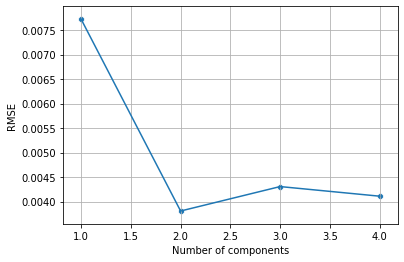

In [55]:
bestgmm_NIK = GMM_best(returns_train_NIK)

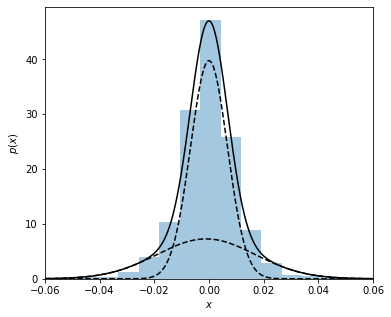

In [56]:
plot_gmm(returns_train_NIK, bestgmm_NIK) 

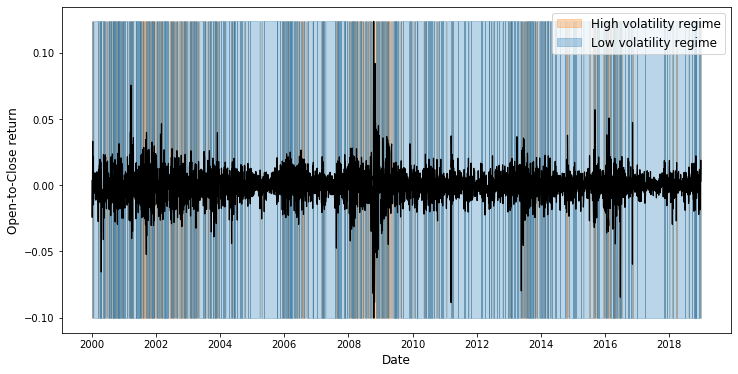

In [57]:
plot_component_changes(returns_train_NIK, bestgmm_NIK)

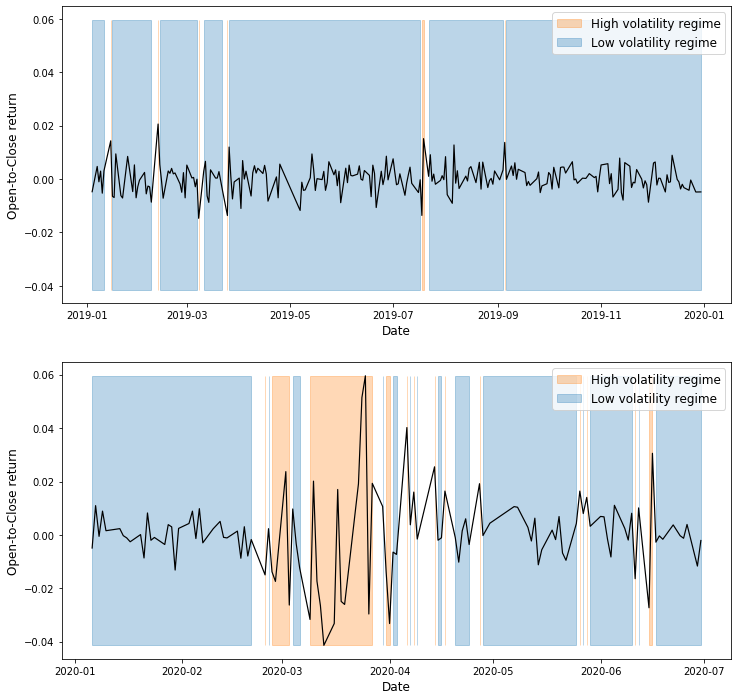

In [58]:
ff, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 12), sharey = True)
assets_test = pd.concat([returns_test2019_NIK, returns_test2020_NIK], axis = 0)

plot_component_changes_test(returns_test2019_NIK, bestgmm_NIK, min(assets_test), max(assets_test), ax1)
plot_component_changes_test(returns_test2020_NIK, bestgmm_NIK, min(assets_test), max(assets_test), ax2)

In [59]:
returns_validation_NIK = returns_train_NIK[returns_train_NIK.index.year == returns_train_NIK.index.year[-1]]
ret_train_NIK = returns_train_NIK[returns_train_NIK.index.year < returns_train_NIK.index.year[-1]]

In [60]:
components_info(ret_train_NIK, bestgmm_NIK)

Proportion of days in regime 0 = 0.17205
Proportion of days in regime 1 = 0.82795

RMSE = 0.00616


In [61]:
components_info(returns_validation_NIK, bestgmm_NIK)

Proportion of days in regime 0 = 0.08824
Proportion of days in regime 1 = 0.91176

RMSE = 0.00381


In [62]:
components_info(returns_test2019_NIK, bestgmm_NIK)

Proportion of days in regime 0 = 0.02991
Proportion of days in regime 1 = 0.97009

RMSE = 0.00420


In [63]:
components_info(returns_test2020_NIK, bestgmm_NIK)

Proportion of days in regime 0 = 0.26957
Proportion of days in regime 1 = 0.73043

RMSE = 0.00766


In [64]:
returns_test_h2019_NIK = returns_test2019_NIK[returns_test2019_NIK.index <= '2019-06-30']

components_info(returns_test_h2019_NIK, bestgmm_NIK)

Proportion of days in regime 0 = 0.03509
Proportion of days in regime 1 = 0.96491

RMSE = 0.00398


### Hidden Markov Models

**Define the functions**

In [65]:
def HMM_best(returns_train, K_max = 6, cov_type = 'full'):
    
    init = time.time()
    random.seed(5)

    # Separating the last year of the training data to consider as the validation year to obtain the best window size
    returns_validation = returns_train[returns_train.index.year == returns_train.index.year[-1]]
    ret_train = returns_train[returns_train.index.year < returns_train.index.year[-1]]

    # Get an array from the time series and reshape it as a 2D array to pass to the HMM
    returns_train_values = ret_train.values.reshape(-1, 1)
    returns_validation_values = returns_validation.values.reshape(-1, 1)
        
    # Compute the volatility with just one sample, which is equivalent to computing the absolute value of each days return
    one_day_valid = abs(returns_validation_values) 
        
    # Fit models with 1 and K_max components. By default, the maximum number of components that evaluated is 6
    K_list = np.arange(1, K_max + 1) 
    
    RMSE_HMM = [None for i in K_list]
    models = [None for i in K_list]
    
    for i in range(len(K_list)):
        # Fit the model for the training absolute return
        models[i] = GaussianHMM(K_list[i], covariance_type = cov_type).fit(returns_train_values)

        # Predict the states of the training data
        state = models[i].predict(returns_train_values)
            
        # Check if there is a state with only 1 day or there is a state defined but with no day labeled there
        unique, unique_counts = np.unique(state, return_counts = True)
        if np.any(unique_counts <= 1) == True or len(unique)!=(i+1): 
            # This introduces NaN into the BIC array instead of an actual value so that this K is ignored as best model
            RMSE_HMM[i] = np.nan
            
        else:  
            # At each iteration, define the new data as the returns data to which at each iteration, a test day is added
            new_data = ret_train
            
            # Initilize a vector to collect the estimated volatility for 
            variance_tomorrow = []

            for j in range(len(returns_validation_values)):

                # Predict the states of the training data and just keep the last one to have the state variable initialized
                state = models[i].predict(new_data.values.reshape(-1, 1))[-1]

                # At each test day, check the state of the last day and depending on it, go check a different row of the transition matrix
                # The state with the largest probability to transition to is the one that is going to be the state of that day
                # The variance estimated for that state is going to be the predicted volatility for that day
                variance_tomorrow.append(np.asscalar(models[i].covars_[np.argmax(models[i].transmat_[state])]))

                # After doing this for each day, the following day is added to the data            
                new_data = pd.concat([new_data, returns_validation.iloc[[j]]], axis = 0)

                # The model is trained again containing this new information
                models[i].fit(new_data.values.reshape(-1, 1))

            RMSE_HMM[i] = mean_squared_error(one_day_valid, np.sqrt(variance_tomorrow), squared = False)
    
    #print(RMSE_HMM) 
    
    # Obtain best model based on minimum RMSE   
    print('Minimum RMSE is {0:.5f} for {1} hidden states \n'.format(np.nanmin(RMSE_HMM), 
                                                                   np.where(RMSE_HMM == np.nanmin(RMSE_HMM))[0][0] + 1))
    
    M_best = models[np.where(RMSE_HMM == np.nanmin(RMSE_HMM))[0][0]]

    # When executed, it presents the main properties of the components of the best model
    for i in range(M_best.n_components):
        print('\nHidden state {0}:'.format(i))
        print('Mean =', M_best.means_[i])
        print('Volatility =', np.sqrt(np.diag(M_best.covars_[i])))

    
    print('\nTransaction probability matrix:\n', M_best.transmat_) 
    
    # Plot the BIC values for the different explored values of K
    plt.plot(K_list, RMSE_HMM)
    sns.scatterplot(np.arange(1, K_max + 1), RMSE_HMM)
    plt.xlabel('Number of components')
    plt.ylabel('RMSE')
    plt.grid()
    
    end = time.time()
    print('Execution time', end - init)
    
    return M_best

In [79]:
def HMM_model(returns_train, cov_type = 'full'):
    
    init = time.time()
    random.seed(0)

    # Separating the last year of the training data to consider as the validation year to obtain the best window size
    returns_validation = returns_train[returns_train.index.year == returns_train.index.year[-1]]
    ret_train = returns_train[returns_train.index.year < returns_train.index.year[-1]]

    # Get an array from the time series and reshape it as a 2D array to pass to the HMM
    returns_train_values = ret_train.values.reshape(-1, 1)
    returns_validation_values = returns_validation.values.reshape(-1, 1)
        
    # Compute the volatility with just one sample, which is equivalent to computing the absolute value of each days return
    one_day_valid = abs(returns_validation_values) 
        
    model = GaussianHMM(n_components = 2, covariance_type = cov_type).fit(returns_train_values)

    # Predict the states of the training data
    state = model.predict(returns_train_values)
            
    # At each iteration, define the new data as the returns data to which at each iteration, a test day is added
    new_data = ret_train
            
    # Initilize a vector to collect the estimated volatility for 
    variance_tomorrow = []

    for j in range(len(returns_validation_values)):

        # Predict the states of the training data and just keep the last one to have the state variable initialized
        state = model.predict(new_data.values.reshape(-1, 1))[-1]

        # At each test day, check the state of the last day and depending on it, go check a different row of the transition matrix
        # The state with the largest probability to transition to is the one that is going to be the state of that day
        # The variance estimated for that state is going to be the predicted volatility for that day
        variance_tomorrow.append(np.asscalar(model.covars_[np.argmax(model.transmat_[state])]))

        # After doing this for each day, the following day is added to the data            
        new_data = pd.concat([new_data, returns_validation.iloc[[j]]], axis = 0)

        # The model is trained again containing this new information
        model.fit(new_data.values.reshape(-1, 1))

    # Obtain best model based on minimum RMSE   
    print('Minimum RMSE is {0:.5f} for 2 hidden states \n'.format(mean_squared_error(one_day_valid, 
                                                                                    np.sqrt(variance_tomorrow), squared = False)))
    
    # When executed, it presents the main properties of the components of the best model
    for i in range(model.n_components):
        print('\nHidden state {0}:'.format(i))
        print('Mean =', model.means_[i])
        print('Volatility =', np.sqrt(np.diag(model.covars_[i])))

    print('\nTransaction probability matrix:\n', model.transmat_) 
    
    end = time.time()
    print('Execution time', end - init)
    
    return model

In [67]:
def plot_hidden_changes(returns, model):

    returns_values = returns.values.reshape(-1, 1)
            
    # Present the plot of the open-close return
    plt.figure(figsize = (12, 6))
    plt.plot(returns.index, returns_values, color = 'k', linewidth = 1.2)
    plt.xlabel('Date', fontsize = 12)
    plt.ylabel('Open-to-Close return', fontsize = 12)
    
    # But classify the days based on the component predicted for the return (because the model is trained with returns)
    states = model.predict(returns_values)
    
    index_order_variance = np.argsort(model.covars_, axis = 0)
    labels = ['Low', 'High'] # The labels in increasing order 
    labels_ordered = []
    for i in enumerate(labels):
        labels_ordered.append(labels[index_order_variance[i[0]][0][0]])   
        
    # Filled based on that given component
    for i in range(len(index_order_variance)):
        plt.fill_between(returns.index, min(returns_values), max(returns_values), where = (states == i), alpha = 0.3, 
                         color = 'C' + str(index_order_variance[i][0][0]), label = labels_ordered[i] + ' volatility regime')
            
    plt.legend(fontsize = 12)

In [68]:
def plot_hidden_changes_test(returns, model, min_assets_test, max_assets_test, ax):

    returns_values = returns.values.reshape(-1, 1)
            
    # Present the plot of the open-close return
    ax.plot(returns.index, returns_values, color = 'k', linewidth = 1.2)
    ax.set_xlabel('Date', fontsize = 12)
    ax.set_ylabel('Open-to-Close return', fontsize = 12)
    
    # But classify the days based on the component predicted for the return (because the model is trained with returns)
    states = model.predict(returns_values)
         
    index_order_variance = np.argsort(model.covars_, axis = 0)
    labels = ['Low', 'High'] # The labels in increasing order 
    labels_ordered = []
    for i in enumerate(labels):
        labels_ordered.append(labels[index_order_variance[i[0]][0][0]])   
        
    # Filled based on that given component
    for i in range(len(index_order_variance)):
        ax.fill_between(returns.index, min_assets_test, max_assets_test, where = (states == i), alpha = 0.3, 
                         color = 'C' + str(index_order_variance[i][0][0]), label = labels_ordered[i] + ' volatility regime')
            
    ax.legend(fontsize = 12)

In [69]:
def states_info(returns, model):
    returns_values = returns.values.reshape(-1, 1)
    oneday_volatility = returns.apply(np.absolute)

    states = model.predict(returns_values)
    for i in np.unique(states):
        print('Proportion of days in regime {0} = {1:.5f}'.format(i, np.count_nonzero(states == i)/len(states)))    
    
    expected_variance = []
    for st in states:
        expected_variance.append(model.covars_[st][0][0])
                
    print('\nRMSE = {0:.5f}'.format(mean_squared_error(oneday_volatility, np.sqrt(expected_variance), squared = False)))

**Analysing the indexes**
- **IBEX**

Minimum RMSE is 0.00504 for 3 hidden states 


Hidden state 0:
Mean = [-0.00212917]
Volatility = [0.01265026]

Hidden state 1:
Mean = [0.0006527]
Volatility = [0.00737019]

Hidden state 2:
Mean = [-0.00054929]
Volatility = [0.02045221]

Transaction probability matrix:
 [[0.28004618 0.45177272 0.2681811 ]
 [0.23922633 0.58341193 0.17736174]
 [0.27650429 0.39379107 0.32970464]]
Execution time 360.02835726737976


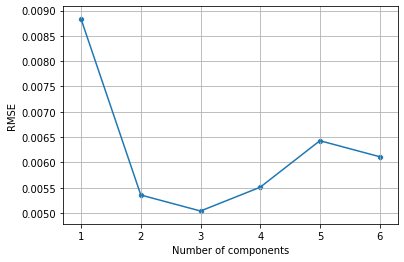

In [70]:
besthmm_IBEX = HMM_best(returns_train_IBEX)

In [80]:
besthmm_IBEX = HMM_model(returns_train_IBEX)

Minimum RMSE is 0.00536 for 2 hidden states 


Hidden state 0:
Mean = [0.00012966]
Volatility = [0.00799699]

Hidden state 1:
Mean = [-0.00099746]
Volatility = [0.01744993]

Transaction probability matrix:
 [[0.61404033 0.38595967]
 [0.51766479 0.48233521]]
Execution time 27.283471822738647


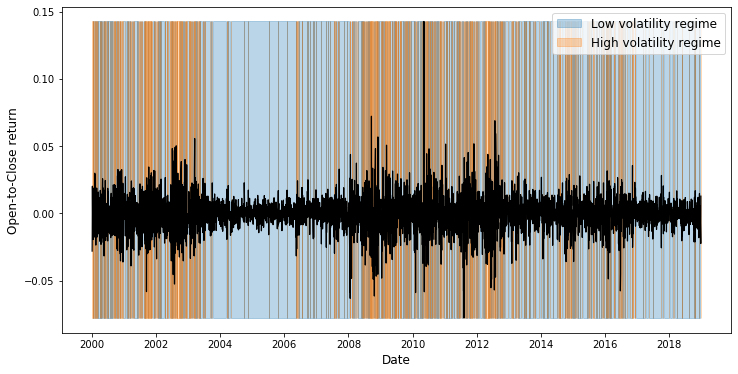

In [81]:
plot_hidden_changes(returns_train_IBEX, besthmm_IBEX)

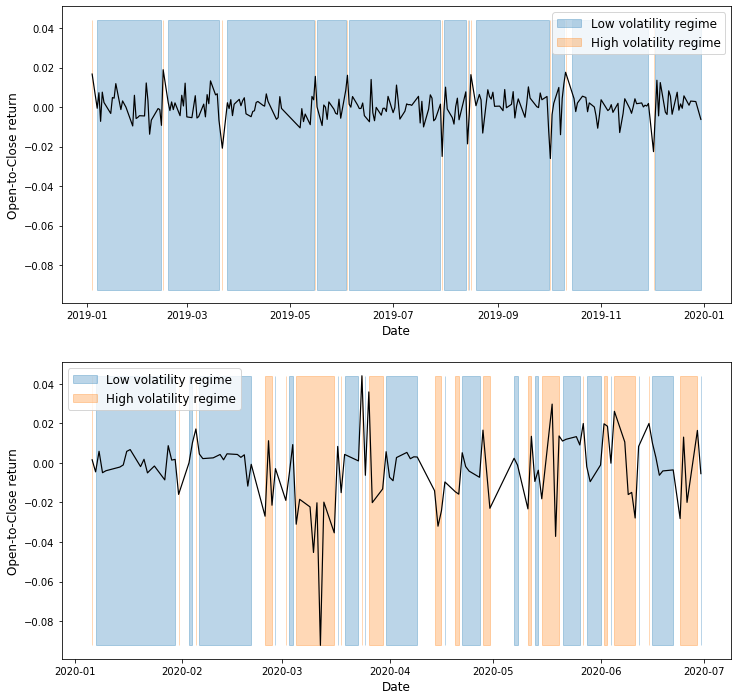

In [82]:
ff, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 12), sharey = True)
assets_test = pd.concat([returns_test2019_IBEX, returns_test2020_IBEX], axis = 0)

plot_hidden_changes_test(returns_test2019_IBEX, besthmm_IBEX, min(assets_test), max(assets_test), ax1)
plot_hidden_changes_test(returns_test2020_IBEX, besthmm_IBEX, min(assets_test), max(assets_test), ax2)

In [83]:
states_info(ret_train_IBEX, besthmm_IBEX)

Proportion of days in regime 0 = 0.78377
Proportion of days in regime 1 = 0.21623

RMSE = 0.00663


In [84]:
states_info(returns_validation_IBEX, besthmm_IBEX)

Proportion of days in regime 0 = 0.93697
Proportion of days in regime 1 = 0.06303

RMSE = 0.00474


In [85]:
states_info(returns_test2019_IBEX, besthmm_IBEX)

Proportion of days in regime 0 = 0.95299
Proportion of days in regime 1 = 0.04701

RMSE = 0.00494


In [86]:
states_info(returns_test2020_IBEX, besthmm_IBEX)

Proportion of days in regime 0 = 0.60000
Proportion of days in regime 1 = 0.40000

RMSE = 0.00982


In [87]:
states_info(returns_test_h2019_IBEX, besthmm_IBEX)

Proportion of days in regime 0 = 0.95614
Proportion of days in regime 1 = 0.04386

RMSE = 0.00488


- **CAC**

Minimum RMSE is 0.00482 for 2 hidden states 


Hidden state 0:
Mean = [-0.00136163]
Volatility = [0.01717134]

Hidden state 1:
Mean = [0.00026598]
Volatility = [0.00709536]

Transaction probability matrix:
 [[0.48214433 0.51785567]
 [0.32613093 0.67386907]]
Execution time 370.88802790641785


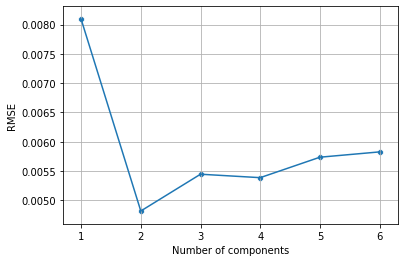

In [88]:
besthmm_CAC = HMM_best(returns_train_CAC)

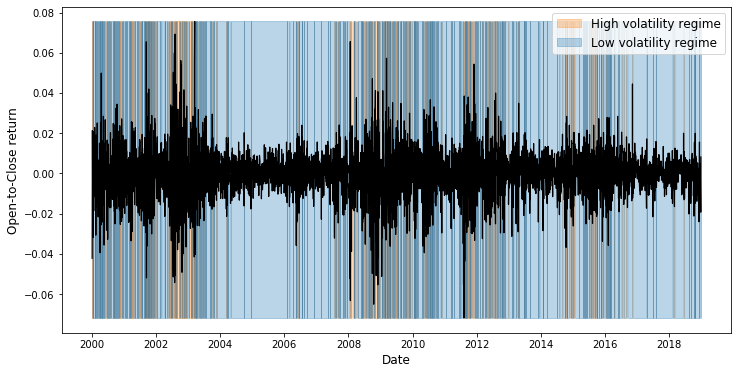

In [89]:
plot_hidden_changes(returns_train_CAC, besthmm_CAC)

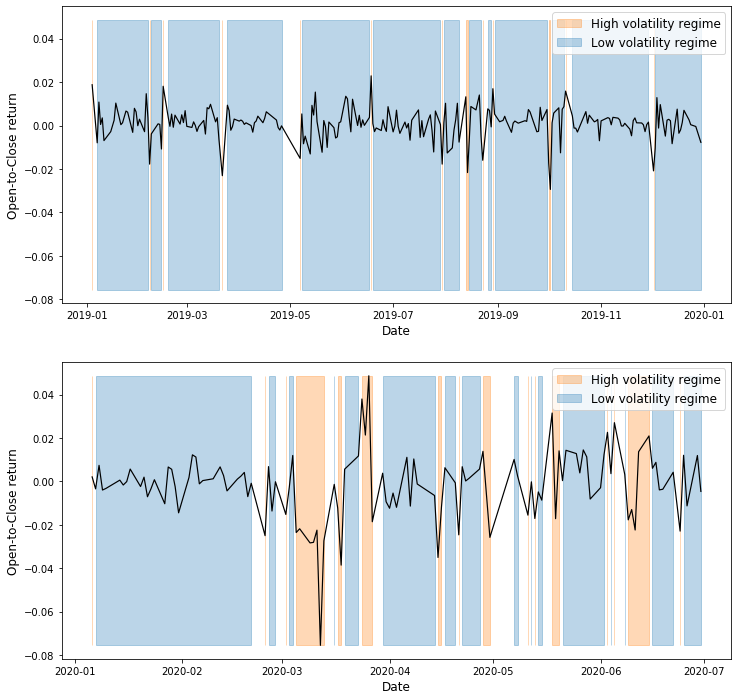

In [90]:
ff, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 12), sharey = True)
assets_test = pd.concat([returns_test2019_CAC, returns_test2020_CAC], axis = 0)

plot_hidden_changes_test(returns_test2019_CAC, besthmm_CAC, min(assets_test), max(assets_test), ax1)
plot_hidden_changes_test(returns_test2020_CAC, besthmm_CAC, min(assets_test), max(assets_test), ax2)

In [93]:
states_info(ret_train_CAC, besthmm_CAC)

Proportion of days in regime 0 = 0.19716
Proportion of days in regime 1 = 0.80284

RMSE = 0.00609


In [94]:
states_info(returns_validation_CAC, besthmm_CAC)

Proportion of days in regime 0 = 0.05042
Proportion of days in regime 1 = 0.94958

RMSE = 0.00420


In [95]:
states_info(returns_test2019_CAC, besthmm_CAC)

Proportion of days in regime 0 = 0.06410
Proportion of days in regime 1 = 0.93590

RMSE = 0.00457


In [96]:
states_info(returns_test2020_CAC, besthmm_CAC)

Proportion of days in regime 0 = 0.29565
Proportion of days in regime 1 = 0.70435

RMSE = 0.00865


In [97]:
states_info(returns_test_h2019_CAC, besthmm_CAC)

Proportion of days in regime 0 = 0.05263
Proportion of days in regime 1 = 0.94737

RMSE = 0.00471


- COMPARE THE IBEX AND THE CAC WITH A NON-EUROPEAN INDEX: **NIKKEI**

Minimum RMSE is 0.00530 for 2 hidden states 


Hidden state 0:
Mean = [2.39843639e-06]
Volatility = [0.00704334]

Hidden state 1:
Mean = [-0.00109189]
Volatility = [0.01821667]

Transaction probability matrix:
 [[0.74610836 0.25389164]
 [0.57034108 0.42965892]]
Execution time 271.3690495491028


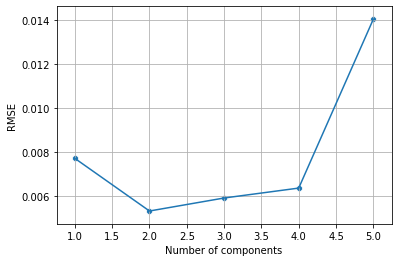

In [98]:
besthmm_NIK = HMM_best(returns_train_NIK)

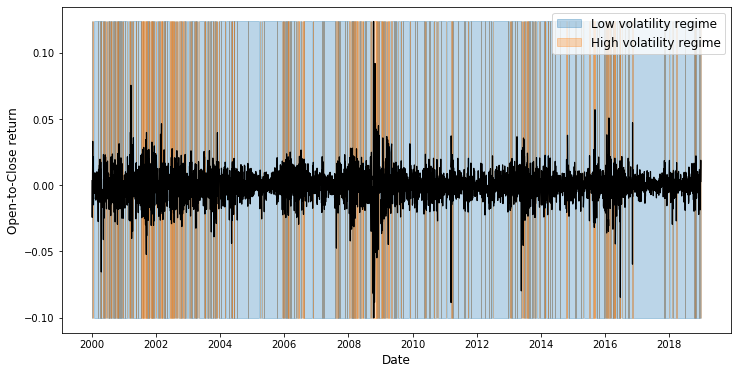

In [99]:
plot_hidden_changes(returns_train_NIK, besthmm_NIK)

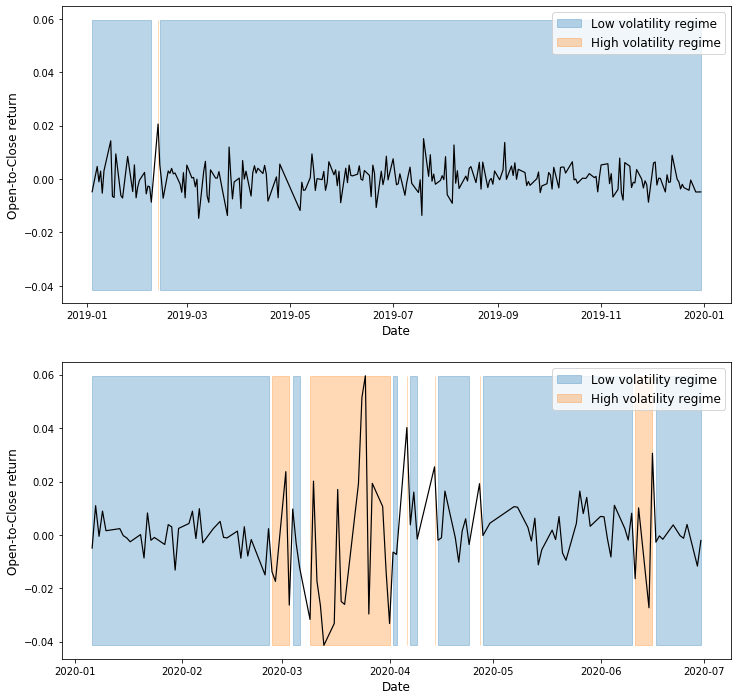

In [100]:
ff, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 12), sharey = True)
assets_test = pd.concat([returns_test2019_NIK, returns_test2020_NIK], axis = 0)

plot_hidden_changes_test(returns_test2019_NIK, besthmm_NIK, min(assets_test), max(assets_test), ax1)
plot_hidden_changes_test(returns_test2020_NIK, besthmm_NIK, min(assets_test), max(assets_test), ax2)

In [101]:
states_info(ret_train_NIK, besthmm_NIK)

Proportion of days in regime 0 = 0.85841
Proportion of days in regime 1 = 0.14159

RMSE = 0.00638


In [102]:
states_info(returns_validation_NIK, besthmm_NIK)

Proportion of days in regime 0 = 0.92437
Proportion of days in regime 1 = 0.07563

RMSE = 0.00413


In [103]:
states_info(returns_test2019_NIK, besthmm_NIK)

Proportion of days in regime 0 = 0.99573
Proportion of days in regime 1 = 0.00427

RMSE = 0.00454


In [104]:
states_info(returns_test2020_NIK, besthmm_NIK)

Proportion of days in regime 0 = 0.75652
Proportion of days in regime 1 = 0.24348

RMSE = 0.00791


In [105]:
states_info(returns_test_h2019_NIK, besthmm_NIK)

Proportion of days in regime 0 = 0.99123
Proportion of days in regime 1 = 0.00877

RMSE = 0.00430


## PREDICT THE REGIMES OF ONE INDEX BASED ON THE MODEL FOR THE OTHER INDEX

### Gaussian Mixture Model

In [106]:
def predict_otherGMM(model_train, model_test, returns_test):

    oneday_volat_test = returns_test.apply(np.absolute).values.reshape(-1, 1)

    # Predict the regimes of the fitted model whose performance want to evaluate for the one day volatility of the other index
    component_pred = model_train.predict(returns_test.values.reshape(-1, 1))
     
    expvol_train = []
    for comp in component_pred:
        expvol_train.append(model_train.covariances_[comp][0][0])
      
    print('Train MSE = {0:.5f}'.format(mean_squared_error(oneday_volat_test, np.sqrt(expvol_train), squared = False)))
        
    # Predict the regimes of the fitted model whose performance want to evaluate for the one day volatility of the other index
    component_true = model_test.predict(returns_test.values.reshape(-1, 1))
     
    expvol_test = []
    for comp in component_true:
        expvol_test.append(model_test.covariances_[comp][0][0])
        
    print('Test MSE = {0:.5f}\n'.format(mean_squared_error(oneday_volat_test, np.sqrt(expvol_test), squared = False)))
        
    
    if model_train.covariances_[0][0][0] <= model_train.covariances_[1][0][0]:
        volat_type_train = [0, 1]
        print('TRAIN: The 1st regime is of low volatility')
    else:
        volat_type_train = [1, 0]
        print('TRAIN: The 2nd regime is of low volatility')
        
    if model_test.covariances_[0][0][0] <= model_test.covariances_[1][0][0]:
        volat_type_test = [0, 1]
        print('TEST: The 1st regime is of low volatility\n')
    else:
        volat_type_test = [1, 0]
        print('TEST: The 2nd regime is of low volatility\n')
    
    if volat_type_train[0] != volat_type_test[0]:
        for i in range(len(component_true)):
            if component_true[i] == 1: # If the component assigned by the original model is 1, change it to 0
                component_true[i] = 0 # So the category of the label 0 of the model that is being tested now is the valid one
            else:
                component_true[i] = 1 
        
    print('Confusion matrix: \n', confusion_matrix(component_true, component_pred, normalize = 'true'))

- **IBEX's GMM (between 2000 and 2018) to predict CAC in 2019 and 2020**

In [107]:
predict_otherGMM(model_train = bestgmm_IBEX, model_test = bestgmm_CAC, returns_test = returns_test2019_CAC)

Train MSE = 0.00531
Test MSE = 0.00488

TRAIN: The 1st regime is of low volatility
TEST: The 1st regime is of low volatility

Confusion matrix: 
 [[1.         0.        ]
 [0.08333333 0.91666667]]


In [108]:
predict_otherGMM(model_train = bestgmm_IBEX, model_test = bestgmm_CAC, returns_test = returns_test2020_CAC)

Train MSE = 0.00814
Test MSE = 0.00813

TRAIN: The 1st regime is of low volatility
TEST: The 1st regime is of low volatility

Confusion matrix: 
 [[1.         0.        ]
 [0.03703704 0.96296296]]


- **CAC's GMM (between 2000 and 2018) to predict IBEX in 2019 and 2020**

In [109]:
predict_otherGMM(model_train = bestgmm_CAC, model_test = bestgmm_IBEX, returns_test = returns_test2019_IBEX)

Train MSE = 0.00471
Test MSE = 0.00513

TRAIN: The 1st regime is of low volatility
TEST: The 1st regime is of low volatility

Confusion matrix: 
 [[0.99559471 0.00440529]
 [0.         1.        ]]


In [110]:
predict_otherGMM(model_train = bestgmm_CAC, model_test = bestgmm_IBEX, returns_test = returns_test2020_IBEX)

Train MSE = 0.00930
Test MSE = 0.00932

TRAIN: The 1st regime is of low volatility
TEST: The 1st regime is of low volatility

Confusion matrix: 
 [[0.98780488 0.01219512]
 [0.         1.        ]]


### Hidden Markov Model

In [111]:
def predict_otherHMM(model_train, model_test, returns_test):

    oneday_volat_test = returns_test.apply(np.absolute).values.reshape(-1, 1)

    # Predict the regimes of the fitted model whose performance want to evaluate for the one day volatility of the other index
    state_pred = model_train.predict(returns_test.values.reshape(-1, 1))
     
    expvol_train = []
    for comp in state_pred:
        expvol_train.append(model_train.covars_[comp][0][0])
      
    print('Train MSE = {0:.5f}'.format(mean_squared_error(oneday_volat_test, np.sqrt(expvol_train), squared = False)))
        
    # Predict the regimes of the fitted model whose performance want to evaluate for the one day volatility of the other index
    state_true = model_test.predict(returns_test.values.reshape(-1, 1))
     
    expvol_test = []
    for comp in state_true:
        expvol_test.append(model_test.covars_[comp][0][0])
        
    print('Test MSE = {0:.5f}\n'.format(mean_squared_error(oneday_volat_test, np.sqrt(expvol_test), squared = False)))
        
    # Check if the label 0 for the state indicates that it is the low or the high volatility regime 
    if model_train.covars_[0][0][0] <= model_train.covars_[1][0][0]:
        volat_type_train = [0, 1]
        print('TRAIN: The 1st regime is of low volatility')
    else:
        volat_type_train = [1, 0]
        print('TRAIN: The 2nd regime is of low volatility')
        
    if model_test.covars_[0][0][0] <= model_test.covars_[1][0][0]:
        volat_type_test = [0, 1]
        print('TEST: The 1st regime is of low volatility\n')
    else:
        volat_type_test = [1, 0]
        print('TEST: The 2nd regime is of low volatility\n')
    
    # If the order of the regimes is not the same, need to interchange the associated label
    if volat_type_train[0] != volat_type_test[0]:
        for i in range(len(state_true)):
            if state_true[i] == 1: 
                state_true[i] = 0
            else:
                state_true[i] = 1 
    # As the label that is interchanged is the train one, the labelling used for constructing the confusion matrix is the test      
        
    print('Confusion matrix: \n', confusion_matrix(state_true, state_pred, normalize = 'true'))

- **IBEX's HMM (between 2000 and 2018) to predict CAC in 2019 and 2020**

In [112]:
predict_otherHMM(model_train = besthmm_IBEX, model_test = besthmm_CAC, returns_test = returns_test2019_CAC)

Train MSE = 0.00516
Test MSE = 0.00457

TRAIN: The 1st regime is of low volatility
TEST: The 2nd regime is of low volatility

Confusion matrix: 
 [[1.         0.        ]
 [0.06666667 0.93333333]]


In [113]:
predict_otherHMM(model_train = besthmm_IBEX, model_test = besthmm_CAC, returns_test = returns_test2020_CAC)

Train MSE = 0.00870
Test MSE = 0.00865

TRAIN: The 1st regime is of low volatility
TEST: The 2nd regime is of low volatility

Confusion matrix: 
 [[1.         0.        ]
 [0.05882353 0.94117647]]


- **CAC's HMM (between 2000 and 2018) to predict IBEX in 2019 and 2020**

In [114]:
predict_otherHMM(model_train = besthmm_CAC, model_test = besthmm_IBEX, returns_test = returns_test2019_IBEX)

Train MSE = 0.00439
Test MSE = 0.00494

TRAIN: The 2nd regime is of low volatility
TEST: The 1st regime is of low volatility

Confusion matrix: 
 [[0.90909091 0.09090909]
 [0.0044843  0.9955157 ]]


In [115]:
predict_otherHMM(model_train = besthmm_CAC, model_test = besthmm_IBEX, returns_test = returns_test2020_IBEX)

Train MSE = 0.00976
Test MSE = 0.00982

TRAIN: The 2nd regime is of low volatility
TEST: The 1st regime is of low volatility

Confusion matrix: 
 [[1.         0.        ]
 [0.01449275 0.98550725]]
